<center><a target="_blank" href="https://academy.constructor.org/"><img src=https://lh3.googleusercontent.com/d/1EmH3Jks5CpJy0zK3JbkvJZkeqWtVcxhB width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>
<hr />

# <h1 align="center">Exercise 2: Multiple Linear Regression (Part 1)</h1>

<hr />
<center>Constructor Academy, 2024</center>

# Task
__Part 1: Model Assessment__

1. Split your data into a train and test set.

2. Run a multiple linear regression using the holdout method on the wine dataset with the goal to predict the alcohol level in wine. For this exercise hold 10% of the train data of the first train-test split as your **validation set**. This requires a second train-test split. Use `sklearn.preprocessing.StandardScaler` for scaling your features. Important: Use the fit and transform methods correctly!

3. Perform a k-fold cross-validation on the whole train dataset from the first split with $k = 10$. This requires the following steps:
  - Build a pipeline for the feature scaling. What are the advantages of using a pipeline? Couldn’t you simply scale the whole dataset before the cross validation?
  - You can use the function `cross_val_score` from `scikit-learn`. The function takes as an argument the desired scoring metric. For the linear regression use $𝑅^2$.

4. Repeat this procedure n times (e.g. 50 times). Before every run shuffle X and y (sklearn.utils.shuffle).
  - Save the cross-validation scores from all $n * k$ runs and plot their distribution.
  - Would you expect that the holdout score is within the range of cross-validation scores? Why?

5. Repeat the above procedure with different scoring metrics for the linear regression, e.g. rmse.

## Bonus: 
1. Write your own k-fold validation function and compare your results with the standard k-fold function from `scikit-learn`.
2. Apply repeated random sub-sampling validation instead of k-fold cross-validation.

## Import Libraries and Preprocess the Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#uncomment according to what you are using, Jupyter notebook or lab
#%load_ext lab_black
# %load_ext nb_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    cross_val_predict,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn import metrics

# import functions from our python module in the functions.py script
from functions import predict_metrics

In [3]:
plt.style.use("ggplot")

In [4]:
data_path = "../data/winequality-white.csv"
data_output_path = "../data/winequality-white_clean.csv"

In [5]:
data = pd.read_csv(data_path, sep=";")
print(data.shape)
data.head()

(4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [7]:
# Select X and y values (predictor and outcome)
X = data.iloc[:, :-2]
y = data.iloc[:, 10]
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40


## Perform Train-Test Split on Wine Data 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=19
)
print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

Training set has 4408 samples.
Testing set has 490 samples.


## Multiple Linear Regression
Run multiple linear regression using the Holdout method on the wine dataset with the goal to predict alcohol level in wine. For this exercise hold 10% of the data as your validation set.

*Note: Hold-out is when you split up your dataset into a ‘train’ and ‘test’ set. The training set is what the model is trained on, and the test set is used to see how well that model performs on unseen data. A common split when using the hold-out method is using 80% of data for training and the remaining 20% of the data for testing.

### Hold out sampling method

In [9]:
X_train_hout, X_val_hout, y_train_hout, y_val_hout = train_test_split(
    X_train, y_train, test_size=0.2, random_state=21
)

### Feature Scaling

Before we fit a model we scale the features. This helps the optimization algorithm to find a better solution. To keep it simple we use here a regular StandardScaler from scikit-learn. It will scale the individual features in such a way that they get a mean of 0 and a standard deviation of 1.

In [10]:
sc = StandardScaler()
X_train_hout_scaled = sc.fit_transform(X_train_hout)
X_val_hout_scaled = sc.transform(X_val_hout)

###  Fit a model

In [11]:
# create the model
lm = LinearRegression()
lm.fit(X_train_hout_scaled, y_train_hout)

print(f"Coefficients: {lm.coef_}")
print(f"Intercept: {lm.intercept_}")

Coefficients: [ 0.44532996  0.09552061  0.05031044  1.23505698 -0.00616662 -0.05536979
  0.02134666 -2.09243548  0.37733467  0.1201901 ]
Intercept: 10.514443183966723


Text(0, 0.5, 'Predictions')

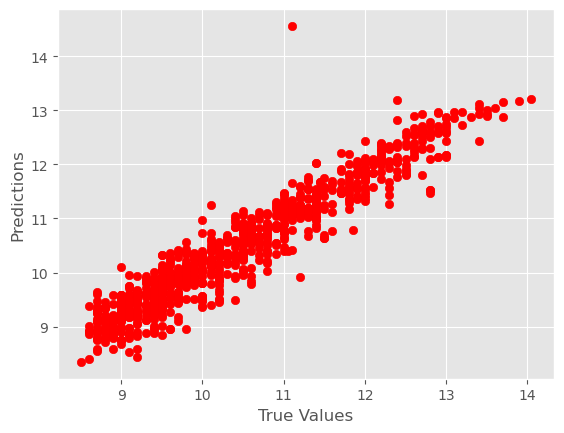

In [12]:
# precidtion
predictions = lm.predict(X_val_hout_scaled)

plt.scatter(y_val_hout, predictions, color="red")
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Evaluation

In [13]:
model_score = lm.score(X_val_hout_scaled, y_val_hout)
model_score

0.901897125936886

In [14]:
predict_metrics(y_val_hout, predictions)

MAE 0.292361939987108
MSE 0.14871299502459642
RMSE 0.3856332390038447
Explained Var Score 0.9020612950871603


In [15]:
diff = y_val_hout - predictions
df = pd.DataFrame({"Actual": y_val_hout, "Predicted": predictions, "Difference": diff})
df.head()

,Actual,Predicted,Difference
2519,9.2,9.434748,-0.234748
1770,10.9,10.504624,0.395376
3274,10.9,11.036147,-0.136147
4518,9.8,10.394283,-0.594283
2701,8.8,9.164079,-0.364079


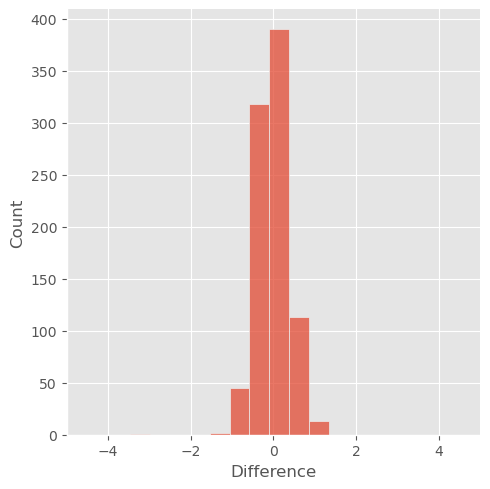

In [16]:
sns.displot(data=df, x="Difference", bins=10)
_ = plt.xlim(-5, 5)

In [17]:
df_coeff = pd.DataFrame(
    {"Feature": data.columns.values[0:10], "Coefficients": lm.coef_}
)
df_coeff

,Feature,Coefficients
0,fixed acidity,0.445330
1,volatile acidity,0.095521
2,citric acid,0.050310
3,residual sugar,1.235057
4,chlorides,-0.006167
5,free sulfur dioxide,-0.055370
6,total sulfur dioxide,0.021347
7,density,-2.092435
8,pH,0.377335
9,sulphates,0.120190


## Pipeline: Feature scaling

__We implement all the scaling, fitting and predicting with a Pipeline. It is easy and is actually the only method that allows to do scaling within a cross validation loop.__

Before we fit a model we scale the features. This helps the optimization algorithm to find a better solution. To keep it simple we use here a regular `StandardScaler` from `scikit-learn`. It will scale the individual features in such a way that they get a mean of 0 and a standard deviation of 1.


In [18]:
sc = StandardScaler()
model = LinearRegression()

pipeline = Pipeline([("data_scaling", sc), ("estimator", model)])

## Cross Validation

<center><a target="_blank"><img src="https://drive.google.com/uc?id=1VnM2vm9lMzoeLrsSuyRNASH7nWXAQTks" width="1000" style="background:none; border:none; box-shadow:none;" /></a> </center>

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=3 becoming 3-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the performance of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

The general procedure is as follows:

    1) Shuffle the dataset randomly.
    2) Split the dataset into k groups
    3) For each unique group:
        - Take the group as a hold out or test data set
        - Take the remaining groups as a training data set
    4) Fit a model on the training set and evaluate it on the test set
    5) Retain the evaluation score and discard the model
    6) Summarize the skill of the model using the sample of model evaluation scores


In [19]:
n = 50
k = 10
cv_scores = np.zeros([n, k])
for i in range(0, n):
    # we need to shuffle the data to ensure that the chosen samples are different each time
    X_train_shuf, y_train_shuf = shuffle(X_train, y_train, random_state=i)
    cv_temp = cross_val_score(pipeline, X_train_shuf, y_train_shuf, cv=k, scoring="r2")
    cv_scores[i, :] = cv_temp

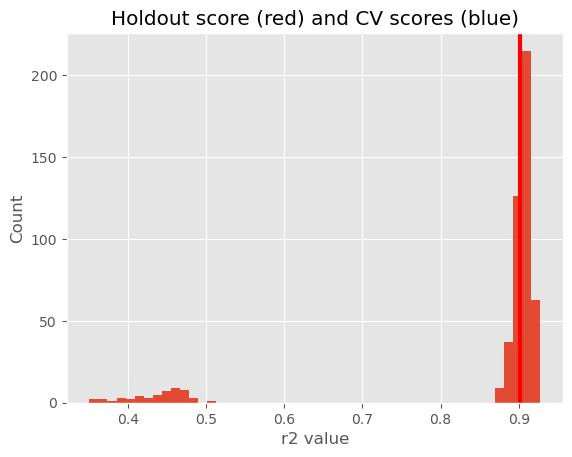

In [20]:
plt.hist(cv_scores.flatten(), 50)
plt.axvline(x=model_score, linewidth=3, color="r")
plt.title("Holdout score (red) and CV scores (blue)")
plt.xlabel("r2 value")
_ = plt.ylabel("Count")

 As we can see, the Holdout score is within the range of cross-validation scores. This is expected, because the Holdout score is the result of one out of many splits in the cross-validation method. However, there is a somehow strange effect, that one out of the 10 values of each cross-validation run, is always significantly lower then the rest.

In [21]:
cv_scores.min(axis=1)

array([0.37730988, 0.40160838, 0.46740796, 0.48423601, 0.3901856 ,
       0.45347285, 0.3852987 , 0.47324267, 0.4581377 , 0.44573091,
       0.47614483, 0.44535969, 0.36608111, 0.44362556, 0.45982427,
       0.39021885, 0.3638596 , 0.43259967, 0.47027034, 0.41848369,
       0.43324784, 0.41395209, 0.46209717, 0.45398092, 0.47605163,
       0.43574975, 0.45636348, 0.42756837, 0.4061251 , 0.44494692,
       0.41173269, 0.35066624, 0.47298597, 0.48896272, 0.35878704,
       0.46567787, 0.43337095, 0.40906905, 0.46152388, 0.43895367,
       0.45498877, 0.4272997 , 0.50699049, 0.46359528, 0.44590215,
       0.47079309, 0.47492443, 0.46568785, 0.42348967, 0.4818336 ])

## Outliers?

The most likely explanation for this, is that there must be a outlier, which significantly influences the score of its validation set.
Before we dig deeper, lets first remember what outliers are. 

__An outlier is an observation that is unlike the other observations.__ It is rare, or distinct, or does not fit in some way and may appear much smaller or bigger than the average value. We use a boxplot to show outliers of each column.

<center><a target="_blank"><img src="https://drive.google.com/uc?id=1DSJlVqOKwgeaOI5_2uEg_Fp_j8yUCj-O" width="500" style="background:none; border:none; box-shadow:none;" /></a> </center>

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

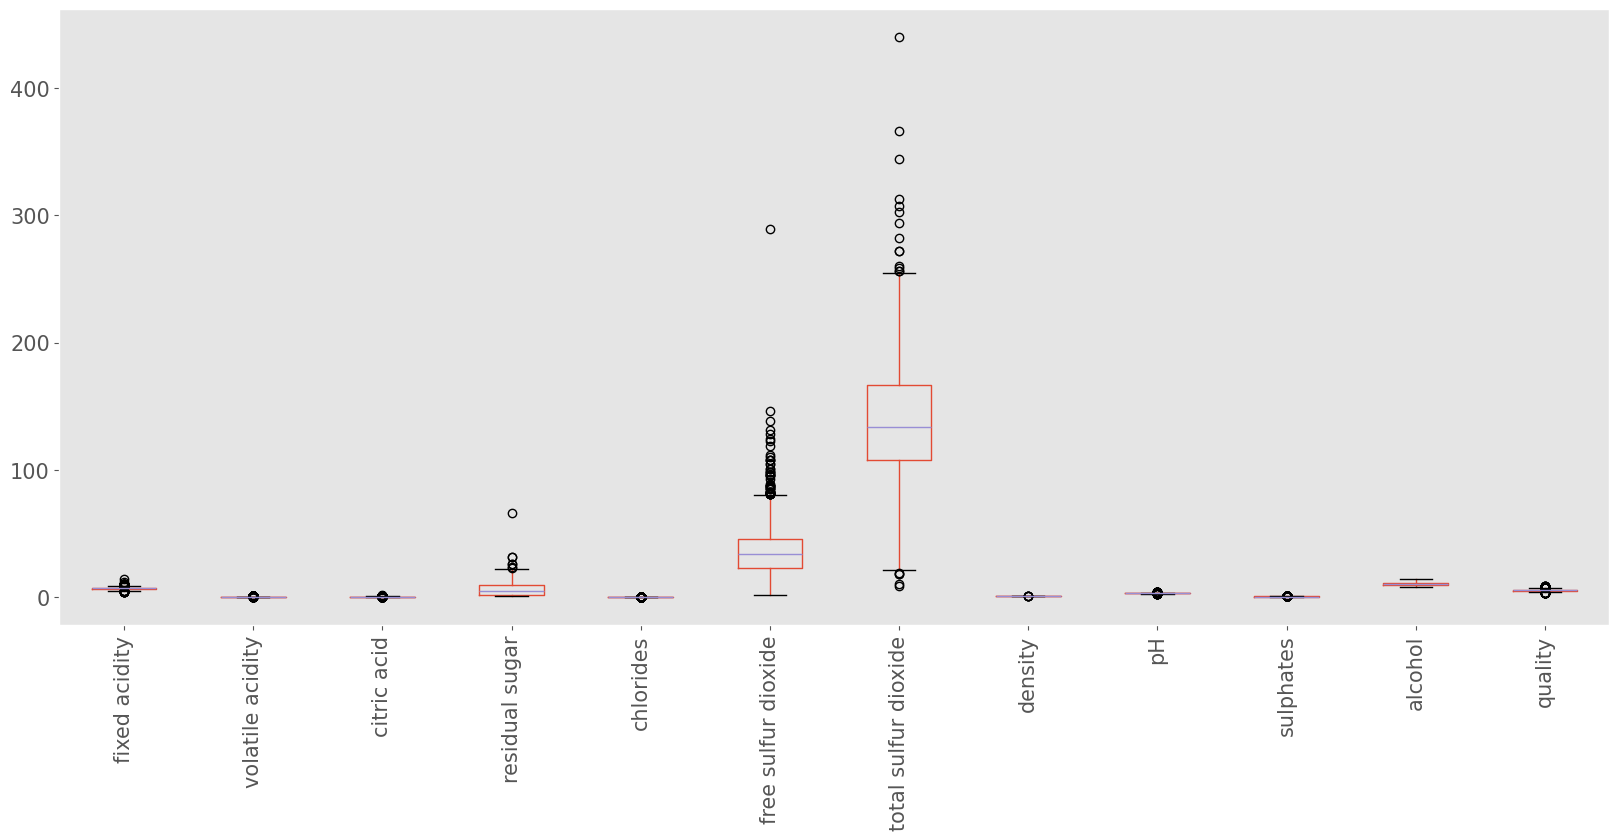

In [22]:
# original data boxplot
_ = data.boxplot(grid=False, rot=90, fontsize=15, figsize=(20, 8))

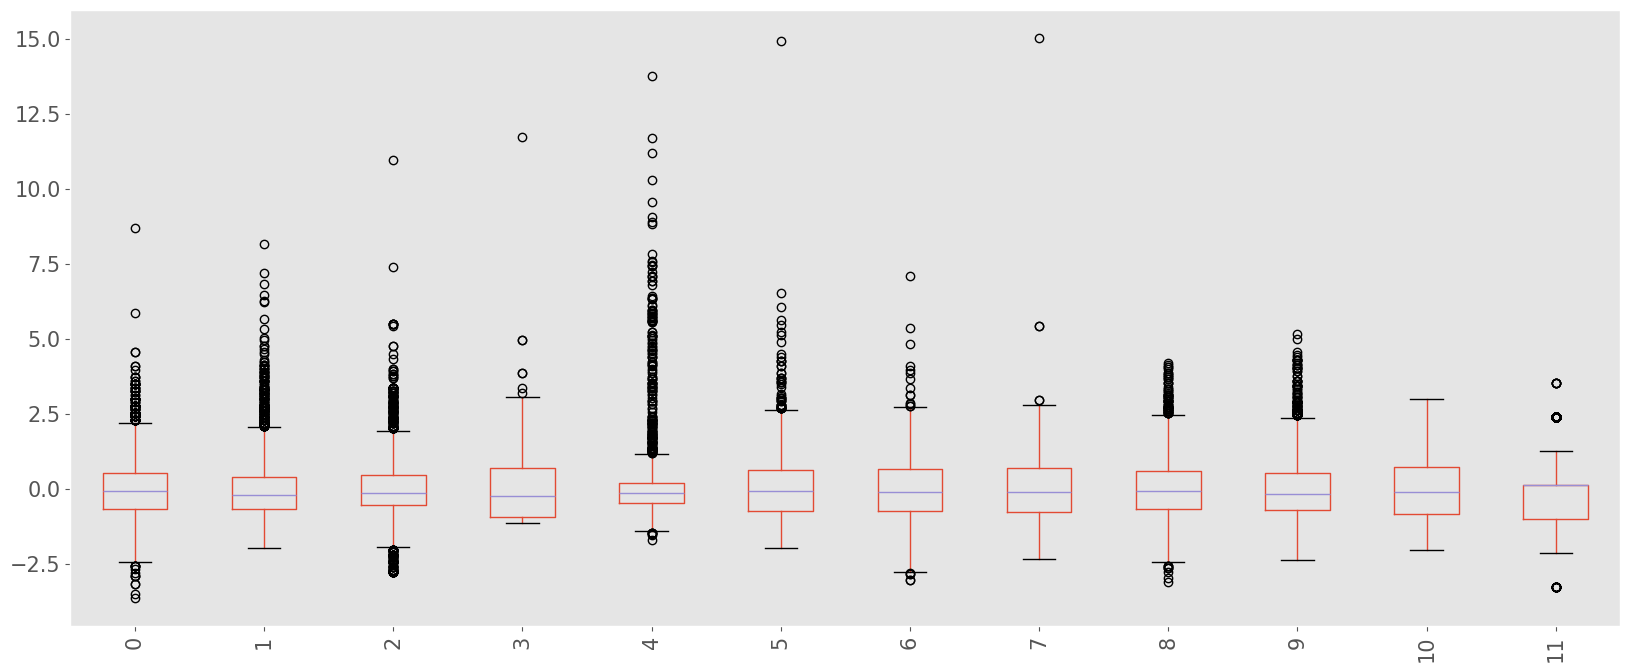

In [23]:
# scalled boxplot
_ = pd.DataFrame(sc.fit_transform(data)).boxplot(
    grid=False, rot=90, fontsize=15, figsize=(20, 8)
)

__By scaling our data, we can see outliers much more clearly. As observed above, we have quite a bit of outliers in out data. Lets see how this affects our model's performance.__

Text(0, 0.5, 'Predictions')

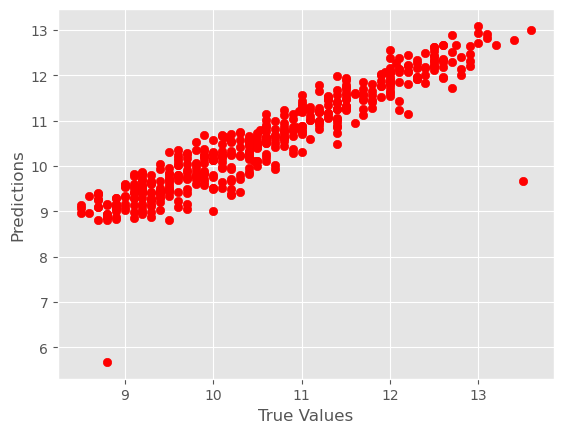

In [24]:
lm_all = pipeline.fit(X_train, y_train)
y_pred_all = lm_all.predict(X_test)
plt.scatter(y_test, y_pred_all, color="red")

plt.xlabel("True Values")
plt.ylabel("Predictions")

In [25]:
predict_metrics(y_test, y_pred_all)

MAE 0.2862765170548144
MSE 0.16878932303900995
RMSE 0.4108397778197846
Explained Var Score 0.8805954611118856


### Removing outliers

It seems like our model also produces outliers. Lets try removing the outliers and see if our model performs better. 
There are many build in libraries that automatically detects and removes outliers from your dataframe. We will have a closer look at these concepts in the Unsupervised learning module. For now lets apply some statistical methods to remove our outliers.

We calculate the Z score for each data point relative to their columnn. We set a cutoff value of 3 and remove any data point that has a Z-score greater than 3. *__Remember:  Z-score is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score. A Z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.__*

https://www.simplypsychology.org/z-score.html

In [26]:
data_clean = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data_clean = data_clean.reset_index()
data_clean = data_clean.drop("index", axis=1)
print(data_clean.shape)
data_clean.head()

(4487, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [27]:
# lets save our clean dataframe into a csv file for later use
data_clean.to_csv(data_output_path)

In [28]:
# Select X and y values (predictor and outcome)
X = data_clean.iloc[:, :-2]
y = data_clean.iloc[:, 10]
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=19
)
print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

Training set has 4038 samples.
Testing set has 449 samples.


In [30]:
n = 50
k = 10
cv_scores = np.zeros([n, k])
for i in range(0, n):
    # we need to shuffle the data to ensure that the chosen samples are different each time
    X_train_shuf, y_train_shuf = shuffle(X_train, y_train, random_state=i)
    cv_temp = cross_val_score(pipeline, X_train_shuf, y_train_shuf, cv=k, scoring="r2")
    cv_scores[i, :] = cv_temp

Text(0.5, 1.0, 'Holdout score (red) and CV scores (blue)')

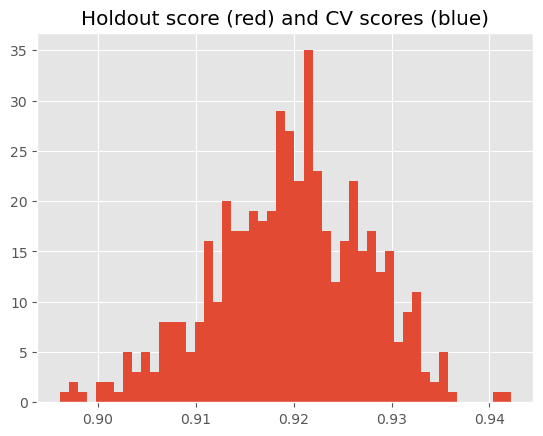

In [31]:
plt.hist(cv_scores.flatten(), 50)
plt.title("Holdout score (red) and CV scores (blue)")

__After removing the outliers, our model has more consistent predictions.__

Text(0, 0.5, 'Predictions')

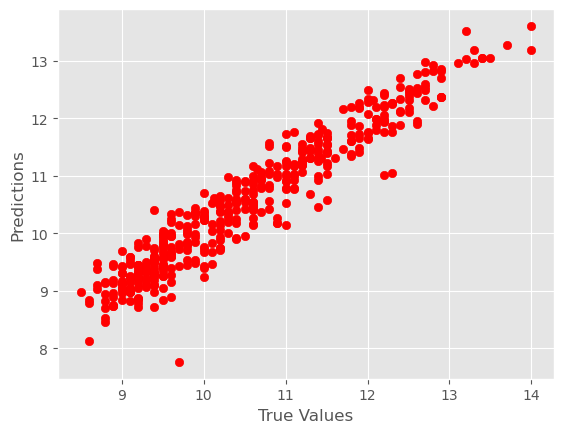

In [32]:
lm_all = pipeline.fit(X_train, y_train)
y_pred_all = lm_all.predict(X_test)
plt.scatter(y_test, y_pred_all, color="red")

plt.xlabel("True Values")
plt.ylabel("Predictions")

### Model Evaluation

In [33]:
predict_metrics(y_test, y_pred_all)

MAE 0.2736958758666269
MSE 0.12330666751735284
RMSE 0.3511504912674235
Explained Var Score 0.9186473104847064


In [34]:
diff = y_test - y_pred_all
df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_all, "Difference": diff})
df.head()

,Actual,Predicted,Difference
2771,12.5,12.392450,0.107550
3021,11.5,11.661187,-0.161187
190,10.2,10.223133,-0.023133
1361,9.8,9.852516,-0.052516
1220,10.0,9.677437,0.322563


(-5.0, 5.0)

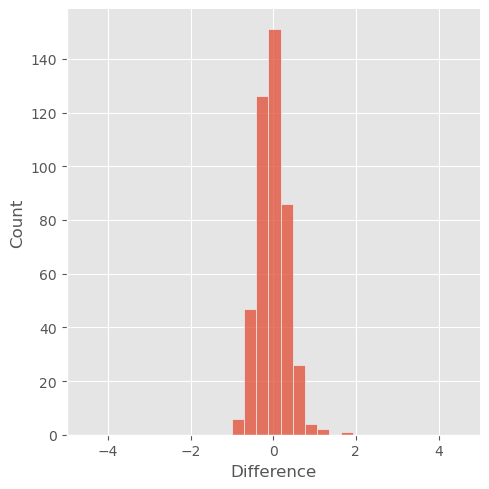

In [35]:
sns.displot(data=df, x="Difference", bins=10)
plt.xlim(-5, 5)

#  Bonus
---
Write your own k-fold validation function and compare results with standard k-fold.

In [36]:
# Kfold cross validation
n_splits = 5

kf = KFold(n_splits=n_splits, random_state=None)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_K, X_test_K = X.iloc[train_index], X.iloc[test_index]
    y_train_K, y_test_K = y.iloc[train_index], y.iloc[test_index]

    sc = StandardScaler()
    X_train_K = sc.fit_transform(X_train_K)
    X_test_K = sc.transform(X_test_K)

    model = LinearRegression()
    model.fit(X_train_K, y_train_K)

    predictions = model.predict(X_test_K)
    print("-----------------------------------------------------")
    predict_metrics(y_test_K, predictions)

# Show the results of the split
print("-----------------------------------------------------")
print(f"Training set has {X_train_K.shape[0]} samples.")
print(f"Testing set has {X_test_K.shape[0]} samples.")

-----------------------------------------------------
MAE 0.29103015590552594
MSE 0.13326062745649583
RMSE 0.36504880147248236
Explained Var Score 0.9041813304331784
-----------------------------------------------------
MAE 0.3169926811734146
MSE 0.17354632411727192
RMSE 0.4165889150196773
Explained Var Score 0.8858577214527676
-----------------------------------------------------
MAE 0.27506251614885546
MSE 0.12480655807056655
RMSE 0.35327971647204226
Explained Var Score 0.901826778769008
-----------------------------------------------------
MAE 0.251121943241189
MSE 0.10108594081911337
RMSE 0.31794015288905136
Explained Var Score 0.9424693259827207
-----------------------------------------------------
MAE 0.2554130466168046
MSE 0.10884889395408419
RMSE 0.32992255751021965
Explained Var Score 0.9309268780870409
-----------------------------------------------------
Training set has 3590 samples.
Testing set has 897 samples.


In [37]:
# KFold avg score
scores = cross_val_score(LinearRegression(), X, y, cv=kf)
accuracy = np.mean(scores)
print("Accuracy:", accuracy)

predictions = cross_val_predict(LinearRegression(), X, y, cv=kf)
print("MSE", metrics.mean_squared_error(y, predictions))

Accuracy: 0.9049544304555726
MSE 0.12832085399912466


--------------
# End of This Notebook